In [24]:
import numpy as np
import pandas as pd
from skopt import gp_minimize, gbrt_minimize 
from skopt.plots import plot_convergence, plot_objective
from rl4greencrab.envs.green_crab_monthly_env import greenCrabMonthEnv
from rl4greencrab.envs.green_crab_monthly_env_norm import greenCrabMonthEnvNormalized
from rl4greencrab.envs.green_crab_movingAvg import greenCrabMonthNormalizedMoving
from rl4greencrab import evaluate_agent, multiConstAction, simulator, environment_simulation, plot_selected_sizes, agent_action_plot
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from stable_baselines3 import PPO, TD3
from sb3_contrib import TQC, RecurrentPPO
from rl4greencrab import LipschitzPPO
import seaborn as sns
from rl4greencrab import plot_agent
import ray

In [2]:
config = {
    "w_mort_scale" : 600,
    "growth_k": 0.70,
    'random_start':True,
    'var_penalty_const': 0
    # "curriculum": True
}
env = greenCrabMonthEnv(config)

/opt/conda/lib/python3.12/site-packages/gymnasium/spaces/box.py:305: UserWarning: WARN: Box high's precision lowered by casting to float32, current high.dtype=float64
  gym.logger.warn(


In [3]:
agent = multiConstAction(env=env, action=np.array([0.0, 0, 0.0]))
noInterventionData = environment_simulation(env, agent)
noInterventionDataDF = pd.DataFrame(noInterventionData)

In [4]:
noInterventionDataDF[noInterventionDataDF['t']==99]

,t,obs0,obs1,act0,act1,act2,rew,rep,crab_pop
99,99,0.0,0.0,0.0,0.0,0.0,-19.806402,0,"[5062.151874651482, 2419.2055594580693, 0.5571..."
199,99,0.0,0.0,0.0,0.0,0.0,-26.235000,1,"[551.567106727743, 4095.522606999551, 3203.980..."
299,99,0.0,0.0,0.0,0.0,0.0,-26.235000,2,"[52.07781915930614, 784.4405525446024, 3089.72..."
399,99,0.0,0.0,0.0,0.0,0.0,-26.235000,3,"[4.6283546370884014, 111.08684052577803, 853.5..."
499,99,0.0,0.0,0.0,0.0,0.0,-26.235000,4,"[4.2316385462362745e-26, 1.475772425341823e-17..."
599,99,0.0,0.0,0.0,0.0,0.0,-26.235000,5,"[3.526365468473057e-27, 1.2298105496382713e-18..."
699,99,0.0,0.0,0.0,0.0,0.0,-26.235000,6,"[0.001443898757662756, 0.27604537531802426, 7...."
799,99,0.0,0.0,0.0,0.0,0.0,-26.235000,7,"[3.8975222637734405e-07, 0.0021238499386771513..."
899,99,0.0,0.0,0.0,0.0,0.0,-26.235000,8,"[1.9487865452608867e-07, 0.0010624522167132515..."
999,99,0.0,0.0,0.0,0.0,0.0,-19.835537,9,"[2070.4928128644647, 989.4898153454837, 0.2278..."


In [5]:
log_crab_pop_series = noInterventionDataDF.loc[noInterventionDataDF['rep'] == 0, 'crab_pop'].apply(
    lambda pop_list: np.log(np.clip(np.array(pop_list, dtype=np.float64), 1e-12, None))
)

In [20]:
def state_heatmap(df, rep=0, use_log=True):
    state_rep = df[df['rep']==0]
    state_rep = state_rep.loc[1:, ['t','crab_pop']]
    if use_log:
        state_rep['state'] = df.loc[:, 'crab_pop'].apply(
            lambda pop_list: np.log(np.array(pop_list, dtype=np.float64)+ 1)
        )
    else:
        state_rep['state'] = df['crab_pop']
    display(state_rep)
    state_rep = state_rep.loc[1:, ['t','state']]
    size_df = pd.DataFrame(state_rep['state'].tolist())
    size_df.columns = [f'size_{i}' for i in range(1, size_df.shape[1]+1)]
    state_rep =  pd.concat([state_rep.drop(columns=['state']), size_df], axis=1)
    # prepare heatmap
    df_melted = state_rep.melt(id_vars='t', value_name='abundance', var_name='size')
    df_melted['size'] = df_melted['size'].str.extract(r'(\d+)').astype(int)
    heatmap_data = df_melted.pivot(index='size', columns='t', values='abundance')
    fig = plt.figure(figsize=(14, 6))
    sns.heatmap(heatmap_data, cmap='viridis', cbar_kws={'label': 'Abundance'})
    plt.xlabel('Time')
    plt.ylabel('Size Class')
    plt.title('Heatmap of State Abundance Over Time by Size')
    plt.savefig("my_seaborn_plot.png")
    plt.show()
    return fig

,t,crab_pop,state
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
95,95,"[0.007208386043849866, 1.31973739220553, 27.91...","[0.007182529809297589, 0.8414539862565481, 3.3..."
96,96,"[0.0007233134226773633, 0.1454377127664757, 4....","[0.0007230519575968884, 0.13578684584721576, 1..."
97,97,"[7.794875105958317e-07, 0.004244185655141966, ...","[7.794872067380143e-07, 0.004235204502024485, ..."
98,98,"[1.8636374831822282e-11, 3.865645186472621e-06...","[1.8636425735789143e-11, 3.865637714808995e-06..."


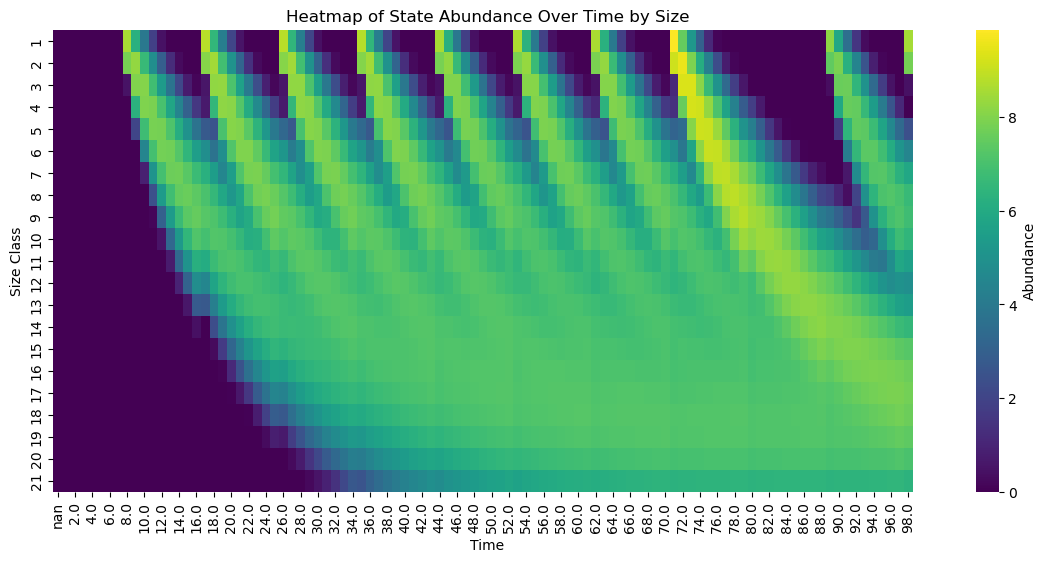

In [21]:
fig = state_heatmap(noInterventionDataDF, rep=0)

In [23]:
fig.savefig("my_seaborn.png")

,t,crab_pop,state
1,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,2,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
95,95,"[0.24862060726209603, 11.388402996746267, 186....","[0.0, 2.432595556631794, 5.2276587861227615, 7..."
96,96,"[0.007933843533255762, 1.4769453629121765, 34....","[0.0, 0.38997601093014034, 3.5531755063534605,..."
97,97,"[0.0007246775935896524, 0.15287909548336048, 5...","[0.0, 0.0, 1.7905935791231944, 4.4643703634148..."
98,98,"[9.743814131096469e-07, 0.005309801047472413, ...","[0.0, 0.0, 0.0, 2.9247044335592483, 5.23514127..."


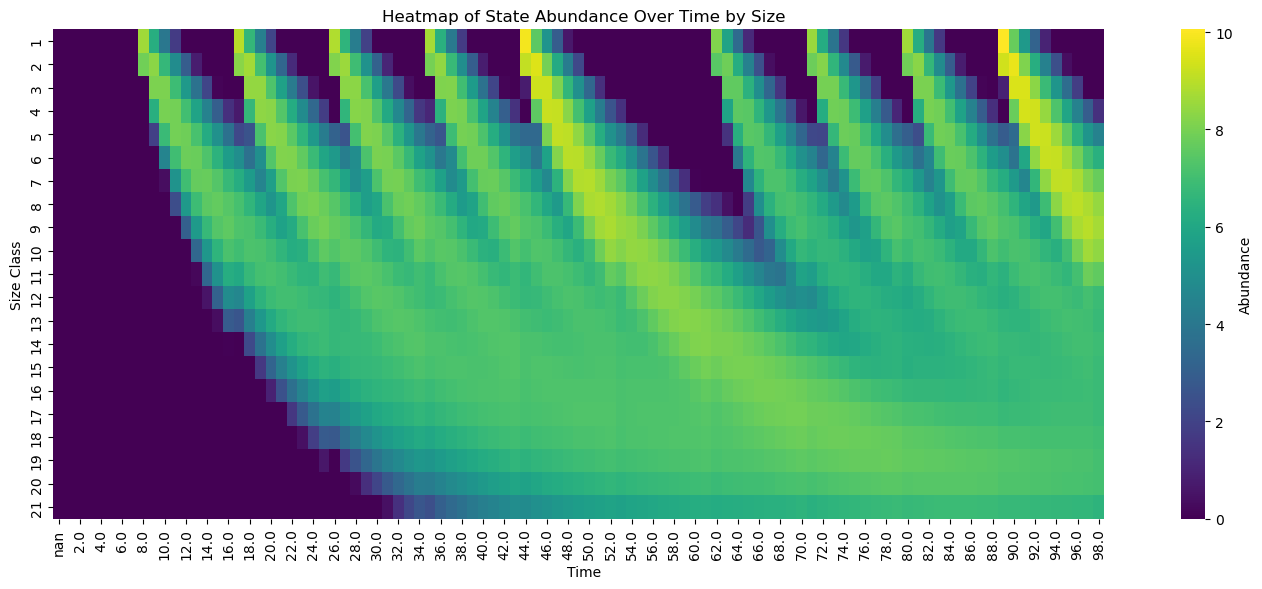

In [115]:
state_heatmap(noInterventionDataDF, rep=1)